In [1]:
#Packages
import datetime #Allows for naming things with the date and time automatically
#Keras packages. Be sure not to mix keras packages with tensorflow.keras, there are some compatibility issues
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras import models
from tensorflow.keras.models import Model 
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks #for things like early stopping and model checkpoints
from tensorflow.keras import backend as K #used in custom root mean squared metric
from kerastuner.tuners import Hyperband #package for tuning hyperparameters, tried it once and it took too long to run
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
#from PIL import Image, ImageDraw, ImageFont, ImageColor
import random 
import pandas as pd
import pydot
from tensorflow.keras.utils import Sequence
from my_classes import DataGenerator, DataGeneratorAug, DataGeneratorMultiInputAug, DataGeneratorPeakMask

In [2]:
#Imports the training set dataframe
train_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project\\Training_set_9_7_centerpoint' 
df=pd.read_csv(os.path.join(train_dataset_dir,"training_dataframe.csv"))
df.shape

(400000, 13)

In [3]:
#Constructs model by defining the build_model method. Each step further explained in README
def build_model():
    model = models.Sequential()                                  
    model.add(layers.Conv2D(32, (3,3) ,activation='relu',padding='same', input_shape=(32,32,1)))
    model.add(layers.MaxPooling2D((2,2),padding="same"))
    model.add(layers.Conv2D(64,(3,3), activation='relu',padding='same'))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Conv2D(64,(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2))
    return model

def get_compiled_model():
    model=build_model()
    def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mse','mae'])
    return model

In [3]:
# Model constructed using the Keras functional API

# def build_model():
#     input_img = Input(shape=(32,32,1),name='image')
#     input_len = Input(shape=(1),name='length')
    
#     conv_1 = Conv2D(32, (3,3) ,activation='relu',padding='same')(input_img)
#     pool_1 = MaxPooling2D((2,2),padding='same')(conv_1)
#     conv_2 = Conv2D(64,(3,3), activation='relu')(pool_1)
#     pool_2 = MaxPooling2D((2,2))(conv_2)
#     conv_3 = Conv2D(64,(3,3), activation='relu')(pool_2)
#     pool_3 = MaxPooling2D((2,2))(conv_3)
#     dropout_1= Dropout(0.1)(pool_3)
#     flatten_1 = Flatten()(dropout_1)
    
#     x = layers.concatenate([flatten_1,input_len])
#     dense_1 = Dense(128, activation='relu')(x)
#     dropout_2= Dropout(0.3)(dense_1)
#     dense_2 = Dense(64, activation='relu')(dropout_2)
#     dropout_3= Dropout(0.3)(dense_2)
#     out=Dense(8)(dropout_3)

#     model=Model(inputs=[input_img,input_len],outputs=out)
#     return model


# def get_compiled_model():
#     model=build_model()
#     def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true)))
#     model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mse','mae'])
#     return model

# model=build_model()
# model.summary()
# plot_model(model,show_shapes=True)

In [4]:
#Creates training set and validation set. Constructs generator
validation_split_frac=0.2 #fraction of data to be set aside as validation
batch_size=200 #Number of images to be sent through the model at a time
array_dim=(32,32,1) #Size to reshape input data before being sent through the model

#Splits dataframe into arrays for training and validation set.
train_partition=df['filename'].values[:int(df.shape[0]*(1-validation_split_frac))]
val_partition=df['filename'].values[int(df.shape[0]*(1-validation_split_frac)):]
partition={"train":train_partition,'validation':val_partition}

#Creates a dictionary with keys as the data filenames and entries as the labels
#label_names=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y']
label_names=['x_coord','y_coord']
ID_list=df['filename'].values
label_list=df[label_names].values
#extra_inputs_list=df['bl'].values
labels={}
#extra_inputs={}
i=0
for ID in ID_list:
    labels[ID]=label_list[i]
    #extra_inputs[ID]=extra_inputs_list[i]
    i+=1

    
#Constructs generators
    
# training_generator=DataGeneratorMultiInputAug(partition['train'],labels,extra_inputs,shuffle=True,directory=train_dataset_dir,batch_size=batch_size,dim=array_dim,norm='divmax')
# validation_generator=DataGeneratorMultiInputAug(partition['validation'],labels,extra_inputs,shuffle=True,directory=train_dataset_dir,batch_size=batch_size,dim=array_dim,norm='divmax')

training_generator=DataGeneratorAug(partition['train'],labels,shuffle=True,directory=train_dataset_dir,batch_size=batch_size,dim=array_dim,norm='divmax')
validation_generator=DataGeneratorAug(partition['validation'],labels,shuffle=True,directory=train_dataset_dir,batch_size=batch_size,dim=array_dim,norm='divmax')

# training_generator=DataGeneratorPeakMask(partition['train'],labels,shuffle=True,directory=train_dataset_dir,batch_size=batch_size,dim=array_dim,norm='divmax')
# validation_generator=DataGeneratorPeakMask(partition['validation'],labels,shuffle=True,directory=train_dataset_dir,batch_size=batch_size,dim=array_dim,norm='divmax')

In [5]:
#Model Training
model_name='run9_8'
model=get_compiled_model()
num_epochs=100
training_steps=int(df.shape[0]*(1-validation_split_frac)/batch_size)
validation_steps=int(df.shape[0]*validation_split_frac/batch_size)
# log_dir = os.path.join("Training_logs\\fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
my_callbacks=[ 
   callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True),
   callbacks.ModelCheckpoint(filepath=os.path.join("Model_Checkpoints",model_name),monitor="val_loss",save_best_only=True)
]
history=model.fit(
    training_generator,
    steps_per_epoch=training_steps,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=num_epochs,
    verbose=2,
    callbacks= my_callbacks,
    workers=2
    )

# history=model.fit(
#     generator=training_generator,
#     validation_data=validation_generator,
#     epochs=num_epochs,
#     verbose=1,
#     callbacks= my_callbacks
#     )


model.save(os.path.join('Models',model_name))
hist_df = pd.DataFrame(history.history) 
hist_csv_file = os.path.join('Model_histories',model_name + '_history.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1600 steps, validate for 400 steps
Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Model_Checkpoints\run9_8\assets
1600/1600 - 250s - loss: 0.0682 - mse: 0.0063 - mae: 0.0504 - val_loss: 0.0258 - val_mse: 6.9328e-04 - val_mae: 0.0132
Epoch 2/100
INFO:tensorflow:Assets written to: Model_Checkpoints\run9_8\assets
1600/1600 - 191s - loss: 0.0412 - mse: 0.0017 - mae: 0.0278 - val_loss: 0.0256 - val_mse: 6.9255e-04 - val_mae: 0.0123
Epoch 3/100
INFO:tensorflow:Assets written to: Model_Checkpoints\run9_8\assets
1600/1600 - 182s - loss: 0.0386 - mse: 0.0015 - mae: 0.0258 - val_loss: 0.0208 - val_mse: 4.6948e-04 - val_mae: 0.0098
Epoch 4/100
INFO:tensorflow:Assets written to: Model_Checkpoints\run9_8\assets
1600/1600 - 191s - loss: 0.0367 - mse: 0.0014 - mae: 0.0246 - val_loss: 0.0208 - val_mse: 4.6971e-04 - val_mae: 0.0101
Epoch 5/100
1600/1600 - 171s - l

In [6]:
model_name='run9_8'
# def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true)))
# model=models.load_model(os.path.join('Models',model_name),compile=False)
# model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mse','mae'])
history_dict=pd.read_csv(os.path.join('Model_histories',model_name + '_history.csv'))

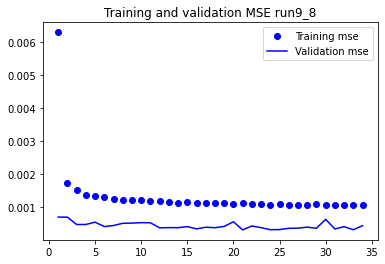

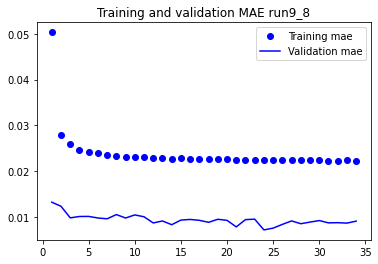

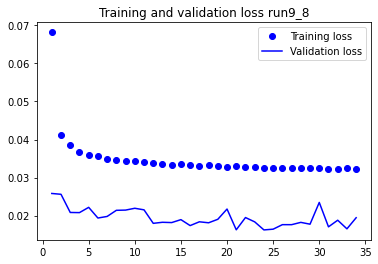

In [7]:
mse = history_dict['mse']
val_mse = history_dict['val_mse']
mae = history_dict['mae']
val_mae = history_dict['val_mae']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(mse) + 1)
os.makedirs(os.path.join('History_Plots',model_name))
plot_dir=os.path.join('History_Plots',model_name)

plt.plot(epochs, mse, 'bo', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and validation MSE '+ model_name)
plt.legend()
plt.savefig(os.path.join(plot_dir,model_name+" mse.png"))


plt.figure()
plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation MAE '+ model_name)
plt.legend()
plt.savefig(os.path.join(plot_dir,model_name+" mae.png"))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss '+ model_name)
plt.legend()
# plt.xlim(10,)
# plt.ylim(0.02,0.06)
plt.savefig(os.path.join(plot_dir,model_name+" loss.png"))

plt.show()

In [63]:
#Creates generators for training and validation images
SEED=5
validation_split_frac=0.2
batch_size=1
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=validation_split_frac)
test_datagen = ImageDataGenerator(rescale=1./255)  
train_generator= train_datagen.flow_from_dataframe(
        df,
        directory=train_dataset_dir,
        x_col="filename",
        y_col=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y'],
        target_size=(32,32),
        shuffle=True,
        color_mode='grayscale',
        seed= SEED,
        class_mode="raw",
        batch_size=batch_size,
        subset='training')

validation_generator= train_datagen.flow_from_dataframe(
        df,
        directory=train_dataset_dir,
        x_col="filename",
        y_col=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y'],
        target_size=(32,32),
        shuffle=True,
        color_mode='grayscale',
        seed= SEED,
        class_mode="raw",
        batch_size=batch_size,
        subset='validation')




# test_generator= test_datagen.flow_from_dataframe(
#         dft,
#         directory=test_dataset_dir,
#         x_col="filename",
#         y_col=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y'],
#         target_size=(32,32),
#         shuffle=True,
#         seed= SEED,
#         class_mode="raw",
#         batch_size=batch_size)

Found 0 validated image filenames.
Found 0 validated image filenames.


In [21]:
# def build_model_hp(hp):
#     model = models.Sequential()                                  
#     model.add(layers.Conv2D(hp.Int('conv1_units',min_value=32,max_value=128,step=64),(hp.Int('kernel_size',min_value=3,max_value=5,step=1),hp.get('kernel_size')) ,activation='relu', input_shape=(32,32,3)))
#     model.add(layers.MaxPooling2D((hp.get('kernel_size')-1,hp.get('kernel_size')-1)))
#     model.add(layers.Conv2D(hp.Int('conv2_units',min_value=64,max_value=128,step=64),(hp.get('kernel_size'),hp.get('kernel_size')), activation='relu'))
#     model.add(layers.MaxPooling2D((hp.get('kernel_size')-1,hp.get('kernel_size')-1)))
#     model.add(layers.Conv2D(hp.Int('conv3_units',min_value=64,max_value=128,step=64),(hp.get('kernel_size'),hp.get('kernel_size')), activation='relu'))
#     model.add(layers.MaxPooling2D((hp.get('kernel_size')-1,hp.get('kernel_size')-1)))
#     model.add(layers.Dropout(hp.Float('dropout_rate',min_value=0.1,max_value=0.5,step=0.1)))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(hp.Int('dense1_units',min_value=64,max_value=256,step=64,default=128), activation='relu'))
#     model.add(layers.Dense(32, activation='relu'))
#     model.add(layers.Dense(8))

#     def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true)))
#     model.compile(optimizer=optimizers.Adam(hp.Choise('learning_rate',values=[1e-2,1e-3,1e-4])), loss=root_mean_squared_error, metrics=['mse','mae'])
#     return model

def build_model_hp(hp):
    model = models.Sequential()                                  
    model.add(layers.Conv2D(hp.Int('conv1_units',min_value=32,max_value=128,step=64),(3,3),activation='relu',input_shape=(32,32,3)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(hp.get('conv1_units')+32,(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(hp.get('conv1_units')+32,(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(hp.Float('dropout_rate',min_value=0.1,max_value=0.5,step=0.1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense1_units',min_value=64,max_value=256,step=64,default=128), activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(8))

    model.compile(optimizer=optimizers.Adam(hp.Choice('learning_rate',values=[1e-2,1e-3,1e-4])), loss=MeanSquaredError(), metrics=['mse','mae'])
    return model


257


In [1]:
# project_name='tuner_trial1'
# tuner= Hyperband(
#     build_model_hp,
#     objective='val_loss',
#     max_epochs=50,
#     executions_per_trial=2,
#     directory=os.path.normpath('C:/'),
#     project_name=project_name
# )
# search_epochs=50
# training_steps=int(df.shape[0]*(1-validation_split_frac)/batch_size)
# validation_steps=int(df.shape[0]*validation_split_frac/batch_size)

# tuner.search(
#     train_generator,
#     steps_per_epoch=training_steps,
#     validation_data=validation_generator,
#     validation_steps=validation_steps,
#     epochs=search_epochs,
#     verbose=1,
#     #callbacks=[callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True)]
# )

# best_hp= tuner.get_best_hyperparameters()[0]
# print(best_hp)

In [ ]:
# def build_model():
#     input_img= Input(shape=(32,32,3))
#     conv_1= Conv2D(32, (3,3) ,activation='relu')(input_img)
#     pool_1= MaxPooling2D((2,2))(conv_1)
#     conv_2= Conv2D(64,(3,3), activation='relu')(pool_1)
#     pool_2= MaxPooling2D((2,2))(conv_2)
#     conv_3= Conv2D(64,(3,3), activation='relu')(pool_2)
#     pool_3= MaxPooling2D((2,2))(conv_3)
#     dropout_1= Dropout(0.5)(pool_3)
#     flatten_1= Flatten()(dropout_1)
#     dense_1= Dense(128, activation='relu')(flatten_1)
#     dense_2= Dense(64, activation='relu')(dense_1)

#     out_1= Dense(1,name='x_coord')(dense_2)
#     out_2= Dense(1,name='y_coord')(dense_2)
#     out_3= Dense(1,name='neighbor1x')(dense_2)
#     out_4= Dense(1,name='neighbor1y')(dense_2)
#     out_5= Dense(1,name='neighbor2x')(dense_2)
#     out_6= Dense(1,name='neighbor2y')(dense_2)
#     out_7= Dense(1,name='neighbor3x')(dense_2)
#     out_8= Dense(1,name='neighbor3y')(dense_2)

#     combined_outputs=layers.concatenate([out_1,out_2,out_3,out_4,out_5,out_6,out_7,out_8],name='outputs')


#     #model=Model(inputs=input_img,outputs=[out_1,out_2,out_3,out_4,out_5,out_6,out_7,out_8])
#     model=Model(inputs=input_img,outputs=combined_outputs)
#     return model

# def get_compiled_model():
#     model=build_model()
#     def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true)))
#     model.compile(
#     optimizer='Adam',
#     loss={'x_coord':root_mean_squared_error, 'y_coord':root_mean_squared_error,
#         'neighbor1x':root_mean_squared_error,'neighbor1y':root_mean_squared_error,
#         'neighbor2x':root_mean_squared_error,'neighbor2y':root_mean_squared_error,
#         'neighbor3x':root_mean_squared_error,'neighbor3y':root_mean_squared_error},
#     loss_weights={'x_coord':1,'y_coord':1,
#         'neighbor1x':1,'neighbor1y':1,
#         'neighbor2x':1,'neighbor2y':1,
#         'neighbor3x':1,'neighbor3y':1},
#     metrics={"x_coord":['mse','mae'],'y_coord':['mse','mae'],
#         'neighbor1x':['mse','mae'],'neighbor1y':['mse','mae'],
#         'neighbor2x':['mse','mae'],'neighbor2y':['mse','mae'],
#         'neighbor3x':['mse','mae'],'neighbor3y':['mse','mae']}
#     )
#     return model

# def get_compiled_model():
#     model=build_model()
#     model.compile(optimizer='Adam', loss=tf.keras.metrics.RootMeanSquaredError(), metrics=['mse','mae'])
#     return model

# model=build_model()
# model.summary()
#plot_model(model,show_shapes=True)
